In [2]:
import matplotlib.pyplot as plt 
import numpy as np
import tensorflow.keras as keras
import os 

activation_2 <keras.layers.core.activation.Activation object at 0x0000024F7BEA6290>


array([ 0.47590118,  0.46417405,  0.41415295,  0.38092102,  0.38868265,
        0.41324284,  0.43458855,  0.43390049,  0.43276282,  0.43139824,
        0.43041268,  0.42977811,  0.42893407,  0.42753204,  0.42504587,
        0.42135581,  0.43323603,  0.49672476,  0.58745848,  0.67720428,
        0.73690951,  0.76220317,  0.75056122,  0.70208891,  0.62033604,
        0.519016  ,  0.43009403,  0.39203434,  0.37852692,  0.39668986,
        0.44047117,  0.4755663 ,  0.48908304,  0.49387713,  0.495042  ,
        0.50192892,  0.49573707,  0.47688623,  0.4772436 ,  0.49632361,
        0.4771333 ,  0.41603079,  0.35615366,  0.30724217,  0.30990038,
        0.35634082,  0.38866174,  0.41133656,  0.42510514,  0.4369506 ,
        0.43739391,  0.43282959,  0.42770533,  0.42403921,  0.42316732,
        0.42276987,  0.42427745,  0.42586789,  0.42714758,  0.42810697,
        0.42839675,  0.43013533,  0.43289583,  0.43510601,  0.43575141,
        0.43475826,  0.4349484 ,  0.43559075,  0.43714932,  0.43

### Load Data

In [3]:
from utils.utils import read_dataset

data_p = 'G:/Meine Ablage/master thesis/code/xai-tsc'
archive = 'ucr'
dataset_name = 'GunPoint'
data_source = 'pointwise'


def readucr(filename):
    data = np.loadtxt(filename, delimiter=',')
    Y = data[:, :150]
    X = data[:, 150:]

    return X, Y
            

def read_dataset(root_dir, archive_name, dataset_name, data_source):
    datasets_dict = {}
    cur_root_dir = root_dir.replace('-temp', '')
    if data_source == 'original': 
        file_name = cur_root_dir + '/archives/' + archive_name + '/' + dataset_name 
    else: 
        file_name = cur_root_dir + '/archives/' + archive_name + '/' + dataset_name  + '/' + data_source + '/'

    x_train, y_train = readucr(file_name + '/' + dataset_name + '_TRAIN')
    x_test, y_test = readucr(file_name + '/' + dataset_name + '_TEST')
    datasets_dict[dataset_name] = (x_train.copy(), y_train.copy(), x_test.copy(),y_test.copy())
    return datasets_dict

data = read_dataset(data_p, archive, dataset_name,  data_source)["GunPoint"]
x_train = data[0]
y_train = data[1]
x_test = data[2]
y_test = data[3]

## Dense Layer


### Check if Gamma = 1 produces same result


In [93]:
from utils.utils import read_dataset


root_dir = 'G:/Meine Ablage/master thesis/code/xai-tsc'
archive_name = 'ucr'
classifier = 'fcn_1.0'
#classifier = 'fcn_mt_dense_itr_'
dataset_name =  'GunPoint'
data_source = 'original'
mode = 'stl'



def calculate_pointwise_attributions(root_dir, archive_name, classifier, dataset_name, data_source, mode, task=1):
    #import tensorflow_addons as tfa
    import tensorflow.keras as keras
    import sklearn
    import os

    if task == 1: 
        datasets_dict = read_dataset(root_dir, archive_name, dataset_name,  'original')
    elif task == 2: 
        datasets_dict = read_dataset(root_dir, archive_name, dataset_name,  data_source)
        
    x_train, y_train, x_test, y_test = datasets_dict[dataset_name]

    # transform to binary labels
    enc = sklearn.preprocessing.OneHotEncoder()
    enc.fit(np.concatenate((y_train, y_test), axis=0).reshape(-1, 1))
    y_train_binary = enc.transform(y_train.reshape(-1, 1)).toarray()
    
    orgx_train = x_train
    orgx_test = x_test
    
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
    x_test  = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

    model_path = f'{root_dir}/results/{archive_name}/{dataset_name}/' \
                                        + f'{classifier.split("_")[0]}/{classifier}/{data_source}/' \
                                        + f'best_model.hdf5'
    #print(model_path)
    
    model = keras.models.load_model(model_path ,compile=False)

    #print(model.layers[-15].name)
    #print(model.summary())

    if mode == 'stl' or classifier == 'fcn_1.0': 
        relu, softm = (-3,-1)

    elif mode == 'mtl': 
        if task == 1:
            if 'ae' in classifier:   
                relu, softm = (-15,-2)
            else: 
                relu, softm = (-4,-2)
            
            #relu, softm = (-10,-2)
        elif task == 2:
            relu, softm = (-4,-1)

            
    w_k_c = model.layers[softm].get_weights()[0]  # weights for each filter k for each class c

    #print(model.layers[relu].name,model.layers[relu])
    # the same input
    new_input_layer = model.inputs
    new_output_layer = [model.layers[relu].output, model.layers[softm].output]
    new_feed_forward = keras.backend.function(new_input_layer, new_output_layer)
    output = []

    for orgx_vals,x_vals,y_vals in [[orgx_train,x_train,y_train],[orgx_test,x_test,y_test]]:
        attr = list()
        for idx,ts in enumerate(x_vals):
            ts = ts.reshape(1, -1, 1)
            [conv_out, predicted] = new_feed_forward([ts])
            cas = np.zeros(dtype=np.float64, shape=(conv_out.shape[1]))

            for k, w in enumerate(w_k_c[:,int(y_vals[idx]-1)]):
                cas += w * conv_out[0, :, k] 
            attr.append([y_vals[idx],orgx_vals[idx],cas])
        output.append(attr)
    return output

att_train, att_test = calculate_pointwise_attributions(root_dir, archive_name, classifier, dataset_name, data_source, mode, task=1)


In [98]:
import pandas as pd
root_dir = 'G:/Meine Ablage/master thesis/code/xai-tsc'
archive_name = 'ucr'
dataset_name =  'GunPoint'
data_source = 'minmax'
mode = 'mtl'
ospath = f'{data_p}/results/{archive}/{dataset_name}/fcn'#data_p + archive + dataset_name + data_source


#results  = pd.DataFrame(columns=['name','similarity','pred att sim'])
hp_array = list()
for res in os.listdir(ospath): 
   
    if True:
    #'sigmoid' in res: #or 'dense' in res or 'ae' in res: 
        
        classifier = res 
        
        ds = os.listdir(ospath + '/' + classifier + '/' )

        for data_source in ds: 
            print(data_source)

            if data_source == 'original': 
                mtl 
            att_train, att_test = calculate_pointwise_attributions(root_dir, archive_name, classifier, 
                                            dataset_name, data_source, mode, task=1)
        
            folder_path = f'{root_dir}/results/{archive_name}/{dataset_name}/' \
                                            + f'{classifier.split("_")[0]}/{classifier}/{data_source}/'

            loaded_model = keras.models.load_model(folder_path + f'best_model.hdf5' ,compile=False)

            metrics  = pd.read_csv(folder_path + 'task1_df_metrics.csv')
            
            print(metrics["accuracy"].values[0])

            att_pred = loaded_model.predict(x_test)[1] # predict attributions

            avg_sim = 0
            avg_sim_pred = 0
            curr_sim_pred_sim = 0
            for ts in range(len(att_test)):
                if 'ae' in classifier:   
                    pred = att_pred[ts].flatten()
                else:
                    pred = att_pred[ts]

                avg_sim += np.corrcoef(y_test[ts],att_test[ts][2])[0,1]
                avg_sim_pred += np.corrcoef(y_test[ts],pred)[0,1]
                curr_sim_pred_sim +=  np.corrcoef(pred,att_test[ts][2])[0,1]
            #new_row = {'name':classifier, 'similarity':avg_sim, 'pred att sim': avg_sim_pred}
            #results.append(new_row, ignore_index=True)
            avg_sim = avg_sim/len(att_test)
            avg_sim_pred = avg_sim_pred/len(att_test)
            curr_sim_pred_sim = curr_sim_pred_sim/len(att_test)

            hp_array.append([classifier+'/'+data_source,
                             avg_sim,
                             avg_sim_pred, 
                             curr_sim_pred_sim, 
                             metrics["accuracy"].values[0],
                             metrics["precision"].values[0],
                             metrics["recall"].values[0]])


results  = pd.DataFrame(hp_array, columns=['name','similarity',
                                           'pred att sim','curr_sim_pred_sim',
                                           'accuracy', 'precision','recall'])
results

pointwise
0.3133333333333333
5/5 [==============================] - 0s 8ms/step
pointwise
1.0
5/5 [==============================] - 0s 9ms/step
minmax
1.0
5/5 [==============================] - 0s 8ms/step
original
1.0
5/5 [==============================] - 0s 9ms/step


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 150 and the array at index 1 has size 1

In [7]:
#from utils.utils import calculate_pointwise_attributions

root_dir = 'G:/Meine Ablage/master thesis/code/xai-tsc'
archive_name = 'ucr'
classifier = 'fcn_mt_dense_1.0'
#classifier = 'fcn_mt_dense_itr_'
dataset_name =  'GunPoint'
data_source = 'pointwise'
mode = 'mtl'

att_train, att_test = calculate_pointwise_attributions(root_dir, archive_name, classifier, dataset_name, data_source, mode, task=1)

len(x_train[0]),len(y_train[0])

activation_2 <keras.layers.core.activation.Activation object at 0x0000024F796C73D0>


(150, 150)

In [19]:
model_path = f'{root_dir}/results/{archive_name}/{dataset_name}/' \
                                        + f'{classifier.split("_")[0]}/{classifier}/{data_source}/' \
                                        + f'best_model.hdf5'

fcn_mt_dense_1 = keras.models.load_model(model_path ,compile=False)

att_train, att_test = calculate_pointwise_attributions(root_dir, archive_name, classifier, dataset_name, data_source, mode, task=1)
dense1_pred = fcn_mt_dense_1.predict(x_test)[1]



G:/Meine Ablage/master thesis/code/xai-tsc/results/ucr/GunPoint/fcn/fcn_mt_sigmoid_0.5/pointwise/best_model.hdf5
yes
activation <keras.layers.core.activation.Activation object at 0x000001E5C764A050>
5/5 [==============================] - 0s 9ms/step


array([[9.99901831e-01, 9.99904633e-01, 9.87168789e-01, ...,
        9.99885559e-01, 9.99880910e-01, 9.99870598e-01],
       [6.86868094e-03, 7.04784971e-03, 2.49207260e-05, ...,
        7.12574553e-03, 7.11853290e-03, 6.56485790e-03],
       [3.68712645e-05, 3.97146105e-05, 1.33586378e-04, ...,
        1.77295573e-04, 3.22846259e-04, 2.10252620e-04],
       ...,
       [1.05068961e-04, 9.99394688e-05, 9.04992248e-06, ...,
        1.01885220e-04, 9.85423030e-05, 1.01683145e-04],
       [7.53364247e-06, 7.11217763e-06, 4.42550780e-04, ...,
        9.46807540e-06, 9.25836775e-06, 1.15062458e-05],
       [9.92516696e-01, 9.92755890e-01, 9.26447392e-01, ...,
        9.91312087e-01, 9.90955472e-01, 9.91018593e-01]], dtype=float32)

In [23]:
# Should be the same: (Something not fixed?)
avg_sim = 0
avg_sim_pred = 0
for ts in range(len(att_test)):
    avg_sim += np.corrcoef(y_test[ts],att_test[ts][2])[0,1]
    avg_sim_pred += np.corrcoef(y_test[ts],dense1_pred[ts])[0,1]

print(avg_sim/len(att_test),avg_sim_pred/len(att_test))


0.9999999999999906 -0.025272760857945074


### Gamma = 0

In [24]:
classifier = 'fcn_mt_dense_0.0'
model_path = f'{root_dir}/results/{archive_name}/{dataset_name}/' \
                                        + f'{classifier.split("_")[0]}/{classifier}/{data_source}/' \
                                        + f'best_model.hdf5'

fcn_mt_dense_1 = keras.models.load_model(model_path ,compile=False)

dense1_pred = fcn_mt_dense_1.predict(x_test)[1]

5/5 [==============================] - 0s 9ms/step


In [57]:
# Should be the same: (Something not fixed?)
avg_sim = 0
avg_sim_pred = 0
att_train, att_test = calculate_pointwise_attributions(root_dir, archive_name, classifier, dataset_name, data_source, mode, task=1)
for ts in range(len(att_test)):
    avg_sim += np.corrcoef(y_test[ts],att_test[ts][2])[0,1]
    avg_sim_pred += np.corrcoef(y_test[ts],dense1_pred[ts])[0,1]

print(avg_sim/len(att_test),avg_sim_pred/len(att_test))

KeyboardInterrupt: 

### Gamma 0.5

In [26]:
classifier = 'fcn_mt_dense_0.5'
model_path = f'{root_dir}/results/{archive_name}/{dataset_name}/' \
                                        + f'{classifier.split("_")[0]}/{classifier}/{data_source}/' \
                                        + f'best_model.hdf5'

fcn_mt_dense_05 = keras.models.load_model(model_path ,compile=False)

dense05_pred = fcn_mt_dense_05.predict(x_test)[1]

5/5 [==============================] - 0s 8ms/step


In [27]:
# Should be the same: (Something not fixed?)
avg_sim = 0
avg_sim_pred = 0
att_train, att_test = calculate_pointwise_attributions(root_dir, archive_name, classifier, dataset_name, data_source, mode, task=1)
for ts in range(len(att_test)):
    avg_sim += np.corrcoef(y_test[ts],att_test[ts][2])[0,1]
    avg_sim_pred += np.corrcoef(y_test[ts],dense05_pred[ts])[0,1]

print(avg_sim/len(att_test),avg_sim_pred/len(att_test))

G:/Meine Ablage/master thesis/code/xai-tsc/results/ucr/GunPoint/fcn/fcn_mt_dense_0.5/pointwise/best_model.hdf5
yes
0.5709618688918913 0.5247286625592978


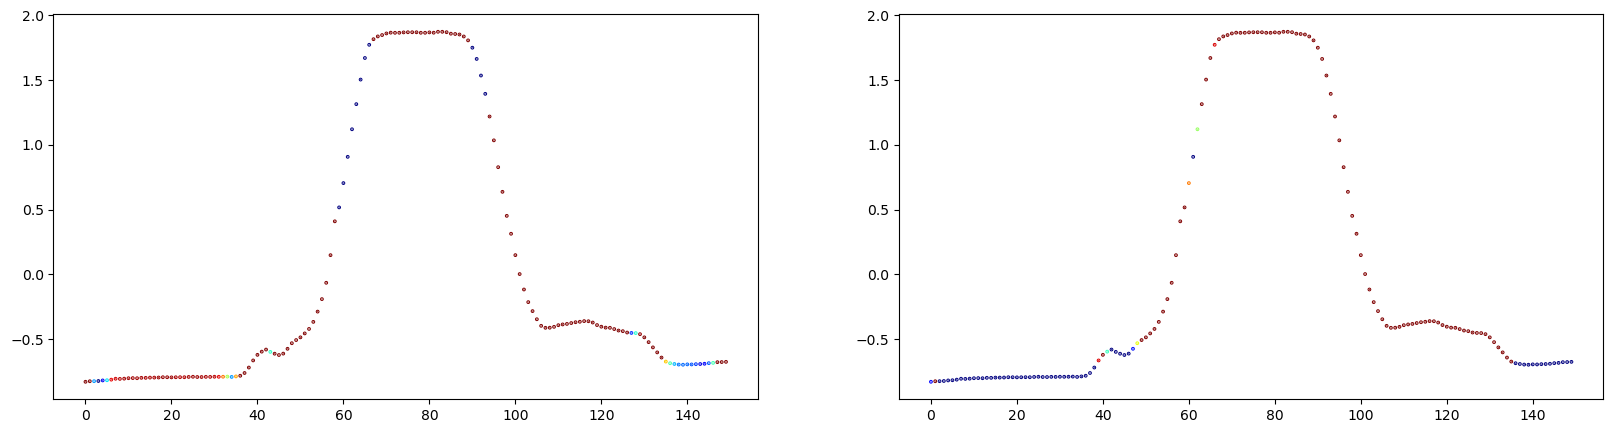

In [33]:
ts = 10
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
axes[0].scatter(np.arange(len(x_test[ts])),
         x_test[ts],c=y_test[ts]*100,cmap='jet', marker='.', s=2, vmin=-100, vmax=100, linewidths=2.0)

axes[1].scatter(np.arange(len(x_test[ts])),
         x_test[ts],c=att_test[ts][2]*100,cmap='jet', marker='.', s=2, vmin=-100, vmax=100, linewidths=2.0)


## Auto Encoder Structure


### Gamma 0


In [62]:
classifier = 'fcn_mt_ae_0.0'
model_path = f'{root_dir}/results/{archive_name}/{dataset_name}/' \
                                        + f'{classifier.split("_")[0]}/{classifier}/{data_source}/' \
                                        + f'best_model.hdf5'

fcn_ae_1 = keras.models.load_model(model_path ,compile=False)

ae1_pred = fcn_ae_1.predict(x_test)[1]

#print(ae1_pred[0].flatten())
# Should be the same: (Something not fixed?)
avg_sim = 0
avg_sim_pred = 0
att_train, att_test = calculate_pointwise_attributions(root_dir, archive_name, classifier, dataset_name, data_source, mode, task=1)
print(len(att_test))
for ts in range(len(att_test)):
    avg_sim += np.corrcoef(y_test[ts],att_test[ts][2])[0,1]
    avg_sim_pred += np.corrcoef(y_test[ts],ae1_pred[ts].flatten())[0,1]

print(avg_sim/len(att_test),avg_sim_pred/len(att_test))

5/5 [==============================] - 0s 23ms/step
G:/Meine Ablage/master thesis/code/xai-tsc/results/ucr/GunPoint/fcn/fcn_mt_ae_0.0/pointwise/best_model.hdf5
yes
activation_3 <keras.layers.core.activation.Activation object at 0x00000291C208FA90>
150
-0.0028537579724681557 0.5494614081567465


In [17]:
%matplotlib inline
ts = 0
#plt.plot(x[ts],c="red")
y_pred = model05.predict(x)[1][0].flatten()
y_pred0 = model00.predict(x)[1][0].flatten()
y_predd = modeld.predict(x)[1][0].flatten()
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))
print(np.corrcoef(y_att[ts],pred_ts_0)[1][0],np.corrcoef(y_att[ts],pred_ts_0s)[1][0],np.corrcoef(y_att[ts],pred_ts_0d)[1][0])

axes[0].scatter(np.arange(len(x[ts])),x[ts],c=y_att[ts]*100,cmap='jet', marker='.', s=2, vmin=-100, vmax=100, linewidths=2.0)
axes[1].scatter(np.arange(len(x[ts])),x[ts],c=y_pred*100,cmap='jet', marker='.', s=2, vmin=-100, vmax=100, linewidths=2.0)
axes[2].scatter(np.arange(len(x[ts])),x[ts],c=y_pred0*100,cmap='jet', marker='.', s=2, vmin=-100, vmax=100, linewidths=2.0)
axes[3].scatter(np.arange(len(x[ts])),x[ts],c=y_predd*100,cmap='jet', marker='.', s=2, vmin=-100, vmax=100, linewidths=2.0)
axes[4].scatter(np.arange(len(att_test[0][1])),att_test[0][1],c=att_test[0][2]*100,cmap='jet', marker='.', s=2, vmin=-100, vmax=100, linewidths=2.0)

NameError: name 'model05' is not defined